# LDA por Gênero - Youtube

In [1]:
import nltk; nltk.download('stopwords')
import sys
#Gerais
import sys
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
#Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
#Plot
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rache\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Criando Lista de Documentos

Nesta análise, criamos uma lista (lista_documentos) em que cada posição corresponde a um canal. Cada posição da lista é formada por uma lista de comentários, ou seja, cada documento para o LDA é um comentário. Isso é feito porque queremos fazer a análise separadamente para cada gênero.

In [2]:
#Lendo arquivo csv
df = pd.read_csv("comentarios1_genero_90-100.csv", encoding='utf-8')

#Removendo colunas desnecessárias
df = df[['text', 'genero']]

#Agrupando dataframe por gêneros e criando uma lista (lista_generos) com os grupos
df_grouped = df.groupby('genero')
lista_generos = []
for genero in df_grouped.groups:
    lista_generos.append(df_grouped.get_group(genero))
lista_documentos = []

#Criando lista de listas de documentos (comentários)
documento = []
for genero in lista_generos:
    for comentario in genero['text']:
        documento.append(gensim.utils.deaccent(comentario)) #removendo acentos
    lista_documentos.append(documento)
    documento = []

## Pré-processamento

Na etapa de pré-processamento, eliminamos tudo que não é considerado interessante para fazer a análise. Dentre isso estão, urls, emails, caracteres especiais e emojis. Além disso, é feita a remoção das chamadas stop words, que são palavras ou muito comuns ou que não fornecem muitas informações, para a análise que queremos fazer, como pronomes e preposições. Nesse caso escolhemos deixar apenas adjetivos, substantivos (excluindo nomes próprios), e verbos (exceto ser, estar, ter e fazer). Por fim, tokenizamos os documentos, o que equivale a quebrar um texto em uma lista de palavras. 

In [3]:
from nltk.corpus import stopwords
##########REMOVENDO TUDO QUE NÃO SÃO PALAVRAS###############
for genero in range(len(lista_documentos)):
    lista_documentos[genero] = [re.sub(r'http\S+', '', str(comentario)) for comentario in lista_documentos[genero]]
    #Remove emails
    lista_documentos[genero] = [re.sub(r'\S*@\S*\s?', '', comentario) for comentario in lista_documentos[genero]]
    # Remove new line characters
    lista_documentos[genero] = [re.sub(r'\s+', ' ', comentario) for comentario in lista_documentos[genero]]
    # Remove distracting single quotes
    lista_documentos[genero] = [re.sub(r"\'", "", comentario) for comentario in lista_documentos[genero]]
    #Remove special characters
    lista_documentos[genero] = [re.sub(r'([^a-zA-Z\s]+?)', '', comentario) for comentario in lista_documentos[genero]]
    
##########REMOVENDO PALAVRAS################################
stop_words = stopwords.words('portuguese')
#Palavras em linguas estrangeiras
stop_words.extend(['you', 'good', 'the', 'to', 'live', 'very', 'your', 'work', 'is', 'my', 'from', 'love', 'and', 'in', 'thank', 'informative', 'are', 'of', 'un', 'english', 'what', 'mi', 'hello', 'el', 'but', 'doctor'])
#Nomes próprios e pronomes de tratamento
stop_words.extend(['drauzio', 'lucy', 'fernando', 'pinto', 'gomes', 'lair', 'ribeiro', 'alvaro', 'galvao', 'gomez', 'kerr', 'dra', 'sr', 'senhora', 'dr', 'senhor'])
#Pronomes
stop_words.extend(['pra', 'vc', 'todos', 'tudo', 'cada', 'nada', 'sobre', 'outros', 'voce'])
#Conjunções
stop_words.extend(['porque', 'pois', 'pq'])
#Advérbios
stop_words.extend(['assim', 'bem', 'ainda', 'agora', 'sim', 'sempre', 'aqui', 'la', 'tbm', 'ai', 'hoje', 'quase', 'logo', 'nao', 'ja', 'so', 'tambem'])
#Verbos frequentes
stop_words.extend(['vai', 'ser', 'ter', 'ta', 'fazer', 'fiz', 'faz', 'vou', 'sao', 'estao'])
#Outros
stop_words.extend(['boa', 'bom', 'obrigado', 'ola'])
#Preposições
stop_words.extend(['ate'])

for genero in range(len(lista_documentos)):
    #Etapa de Tokenização
    lista_documentos[genero] = [gensim.utils.simple_preprocess(str(comentario), deacc=True) for comentario in lista_documentos[genero]]
    #Removendo stop words
    lista_documentos[genero] = [[word for word in comentario if word not in stop_words] for comentario in lista_documentos[genero]]



## Modelo LDA e Resultados

Nesta parte, criamos um loop para percorrer cada gênero da lista_documentos e geramos o modelo LDA para eles. Além disso, é criado o dataframe que servirá como base para gerar a tabela html com os resultados

In [16]:
from IPython.display import display, HTML
##################CRIAÇÃO DO DATAFRAME PARA ARMAZENAR OS RESULTADOS#################
resultado = pd.DataFrame()
resultado['Gênero'] = ''
resultado['Palavras'] = ''

##################CRIANDO MODELO PARA CADA GÊNERO##################################
lista_lda = []
for genero in range(len(lista_documentos)):
    #Gerando tópico para o gênero
    dicionario = corpora.Dictionary(lista_documentos[genero])

    corpus = [dicionario.doc2bow(comentario) for comentario in lista_documentos[genero]]
    modelo_lda = LdaMulticore(corpus=corpus,
                        id2word=dicionario,
                        num_topics=1, 
                        random_state=42,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True,
                        alpha = 0.9,
                        eta = 0.3)
    lista_lda.append(modelo_lda)
    #Criando lista de palavras do tópico
    palavras = ''
    for palavra in modelo_lda.show_topics(num_topics=1, num_words=20, formatted=False)[0][1]:
        palavras = palavras + ' ' + palavra[0]
        
    #Adicionando os tópicos para o dataframe de resultados
    resultado.loc[len(resultado)] = [lista_generos[genero]['genero'].values[0], palavras]

#Criando tabela html para exibir resultados
display(HTML(resultado.to_html()))
#Código da tabela html
#print(resultado.to_html())

,Gênero,Palavras
0,F,dias deus ivermectina tomar dia covid obrigada pessoas video virus pode sintomas medico casa parabens gente dor olfato comprimidos tomei
1,M,dias ivermectina virus video pessoas covid dia pode deus tomar medico sintomas comprimidos parabens brasil doutor olfato casa dor tratamento


## Word Cloud

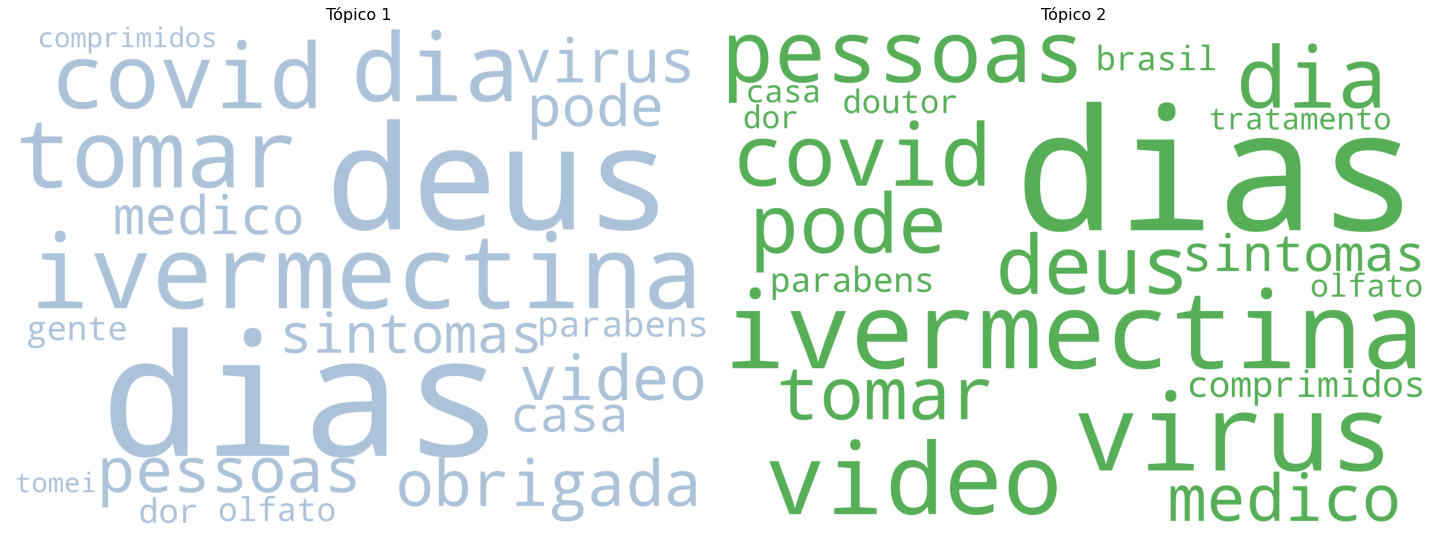

In [31]:
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = []
topics.append(lista_lda[0].show_topics(num_words=20, formatted=False))
topics.append(lista_lda[1].show_topics(num_words=20, formatted=False))
fig, axes = plt.subplots(1, 2, figsize=(20,20), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][0][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=600)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Tópico ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()